In [1]:
# Imports

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Load data
mat_file = loadmat('../sample_1.mat')


# Plotting Sample 1

In [2]:
%matplotlib notebook

data = mat_file['data'][0]
plt.plot(data)

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

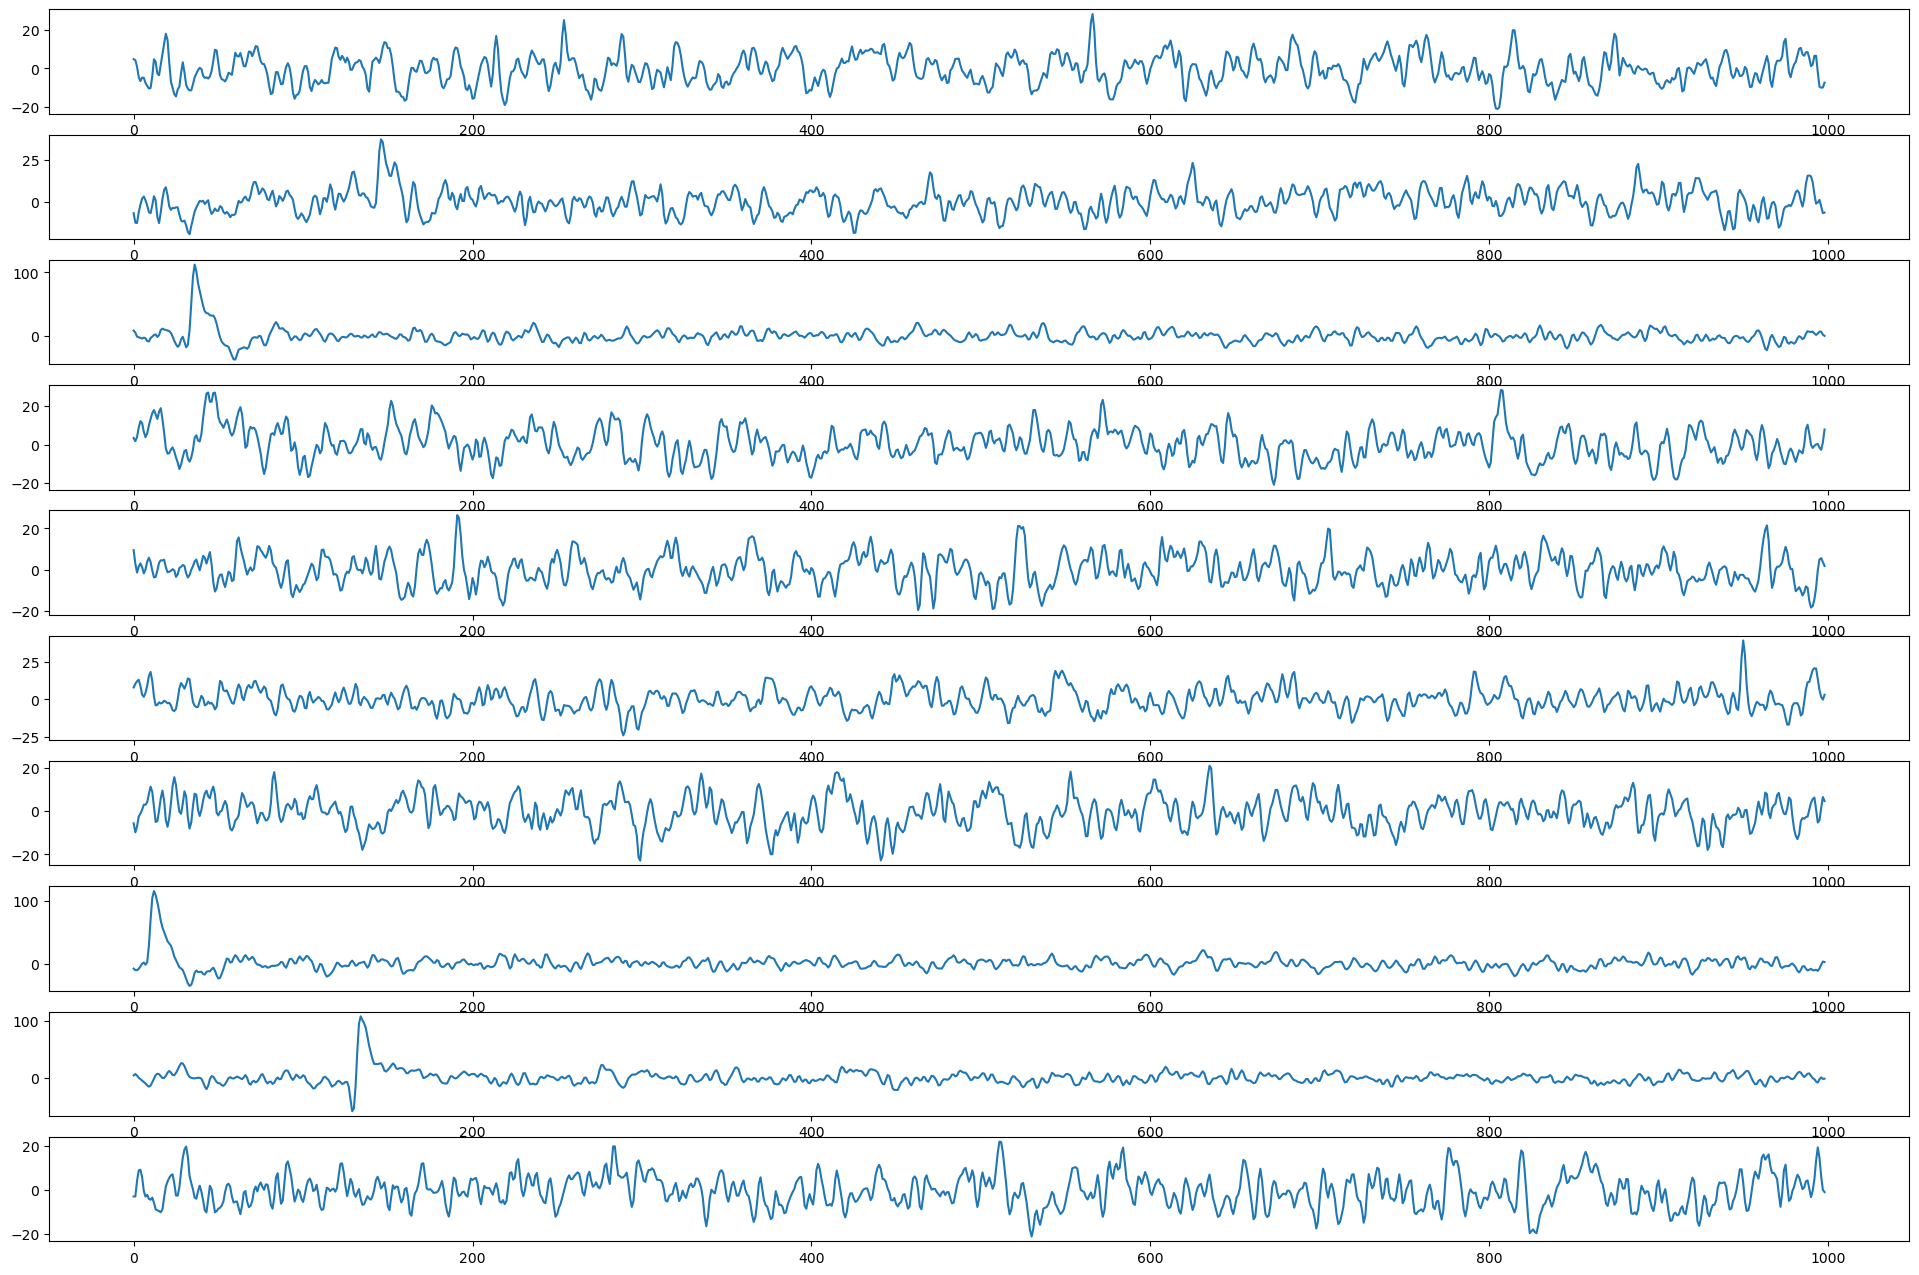

In [3]:
%matplotlib inline
data = mat_file['data'][0][:10000]
spike_times = mat_file['spike_times'][0][0][0]

# TODO: Plot Spiketimes, fix x axis (include offset of continues time)

SUBPLOT_SIZE = 1000
N_SUBPLOTS = data.shape[0]//SUBPLOT_SIZE

fig, ax = plt.subplots(nrows=N_SUBPLOTS, ncols=1, figsize=(24,16))

for i in range(0, N_SUBPLOTS):
    ax[i].plot(data[i*SUBPLOT_SIZE:i*SUBPLOT_SIZE+SUBPLOT_SIZE-1])
    
    
    
plt.show() 
    

## Spikes by Classes

In [4]:
def plot_clusters_by_class(class_label):
    data = mat_file['data'][0]
    classes = mat_file['spike_class'][0][0][0]
    spike_times = mat_file['spike_times'][0][0][0]
    
    spikes = spike_times[np.where(classes==class_label)]
    
    fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(24,16))
    
    for i in range(18):

        ax[i//3][i%3].plot(data[spikes[i]-50:spikes[i]+50])
        
        
    plt.show()

# for debugging
# plot_clusters_by_class(2)

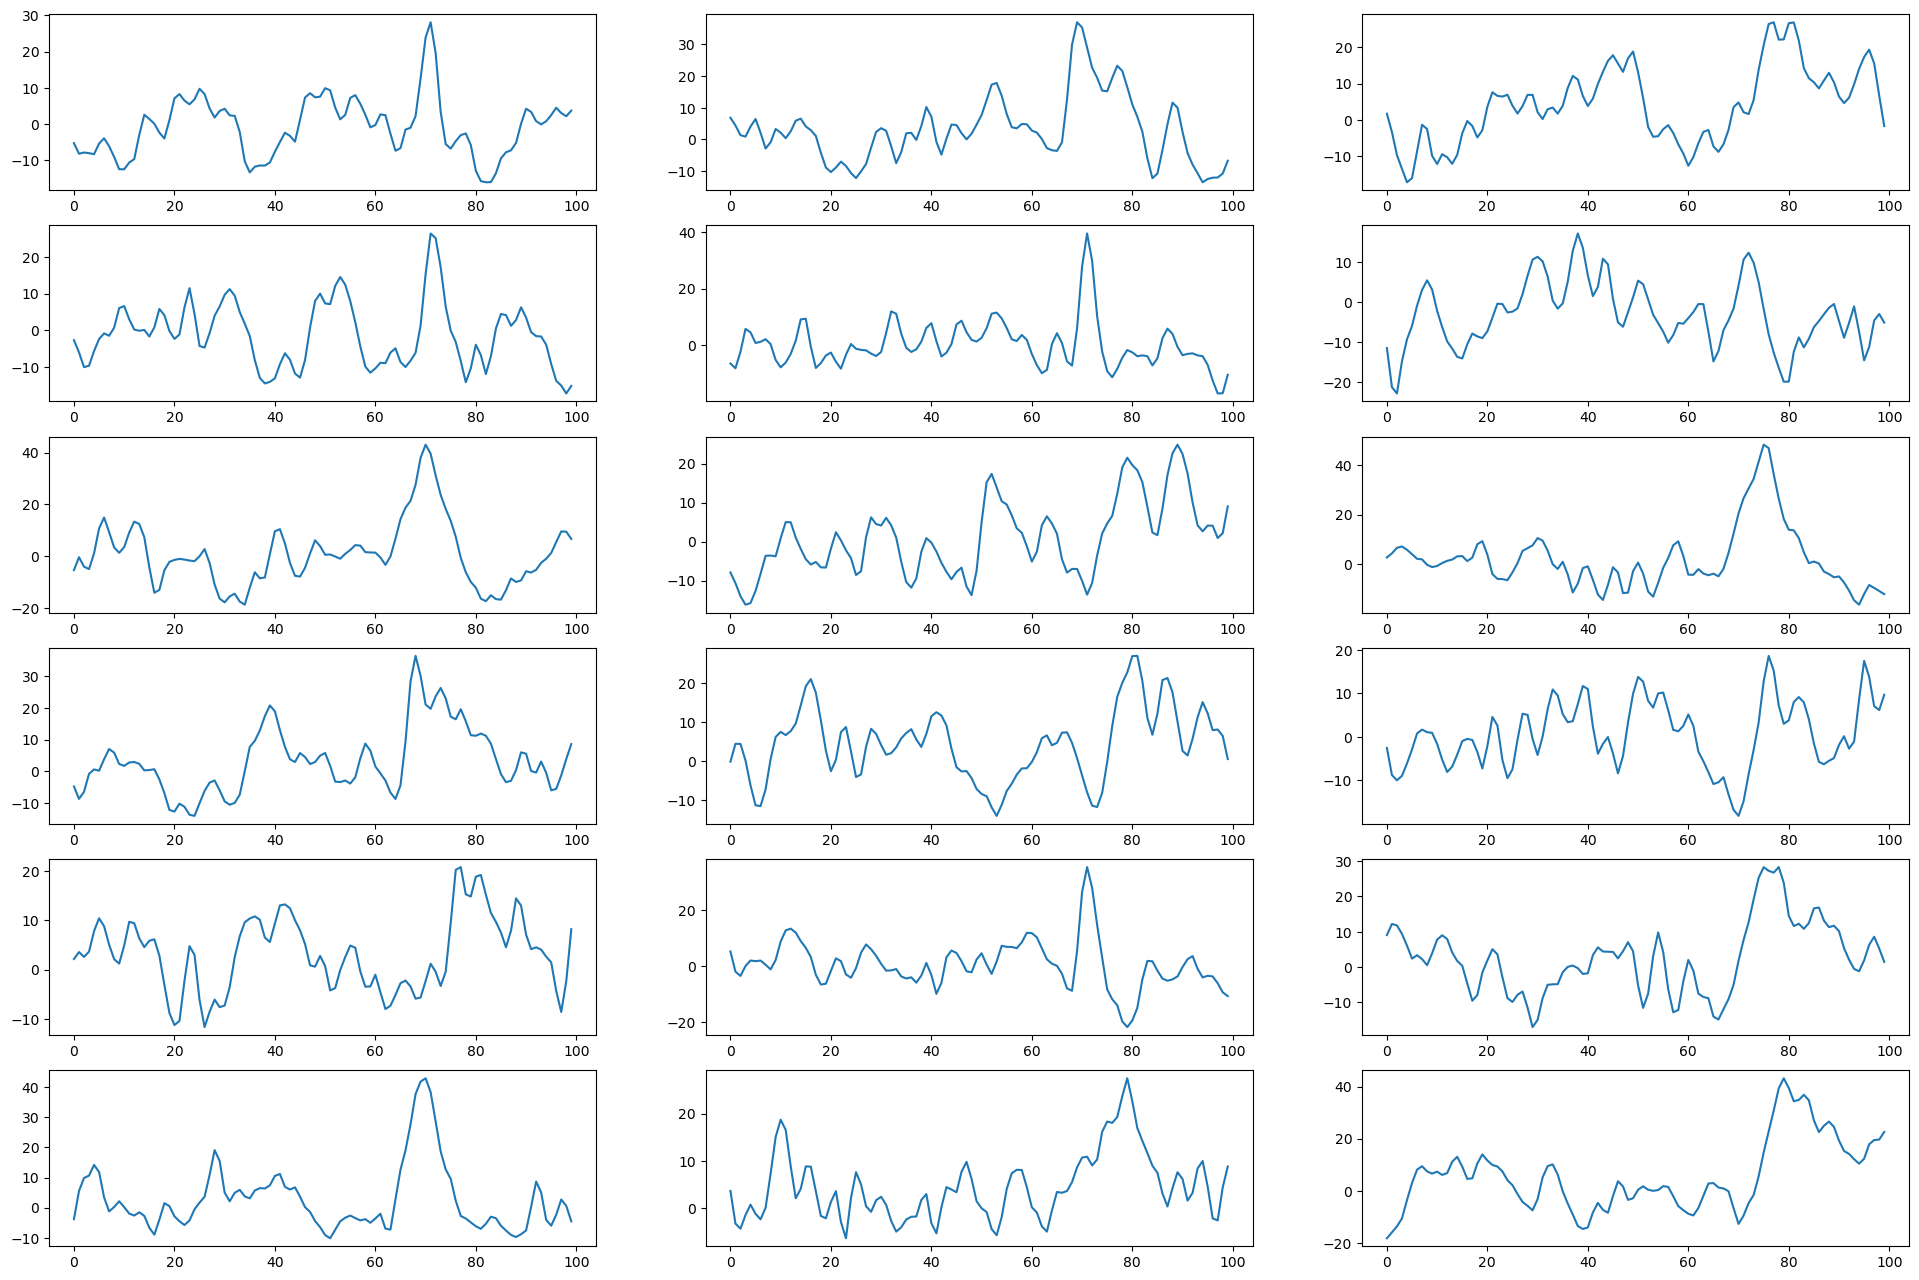

In [5]:
plot_clusters_by_class(0)

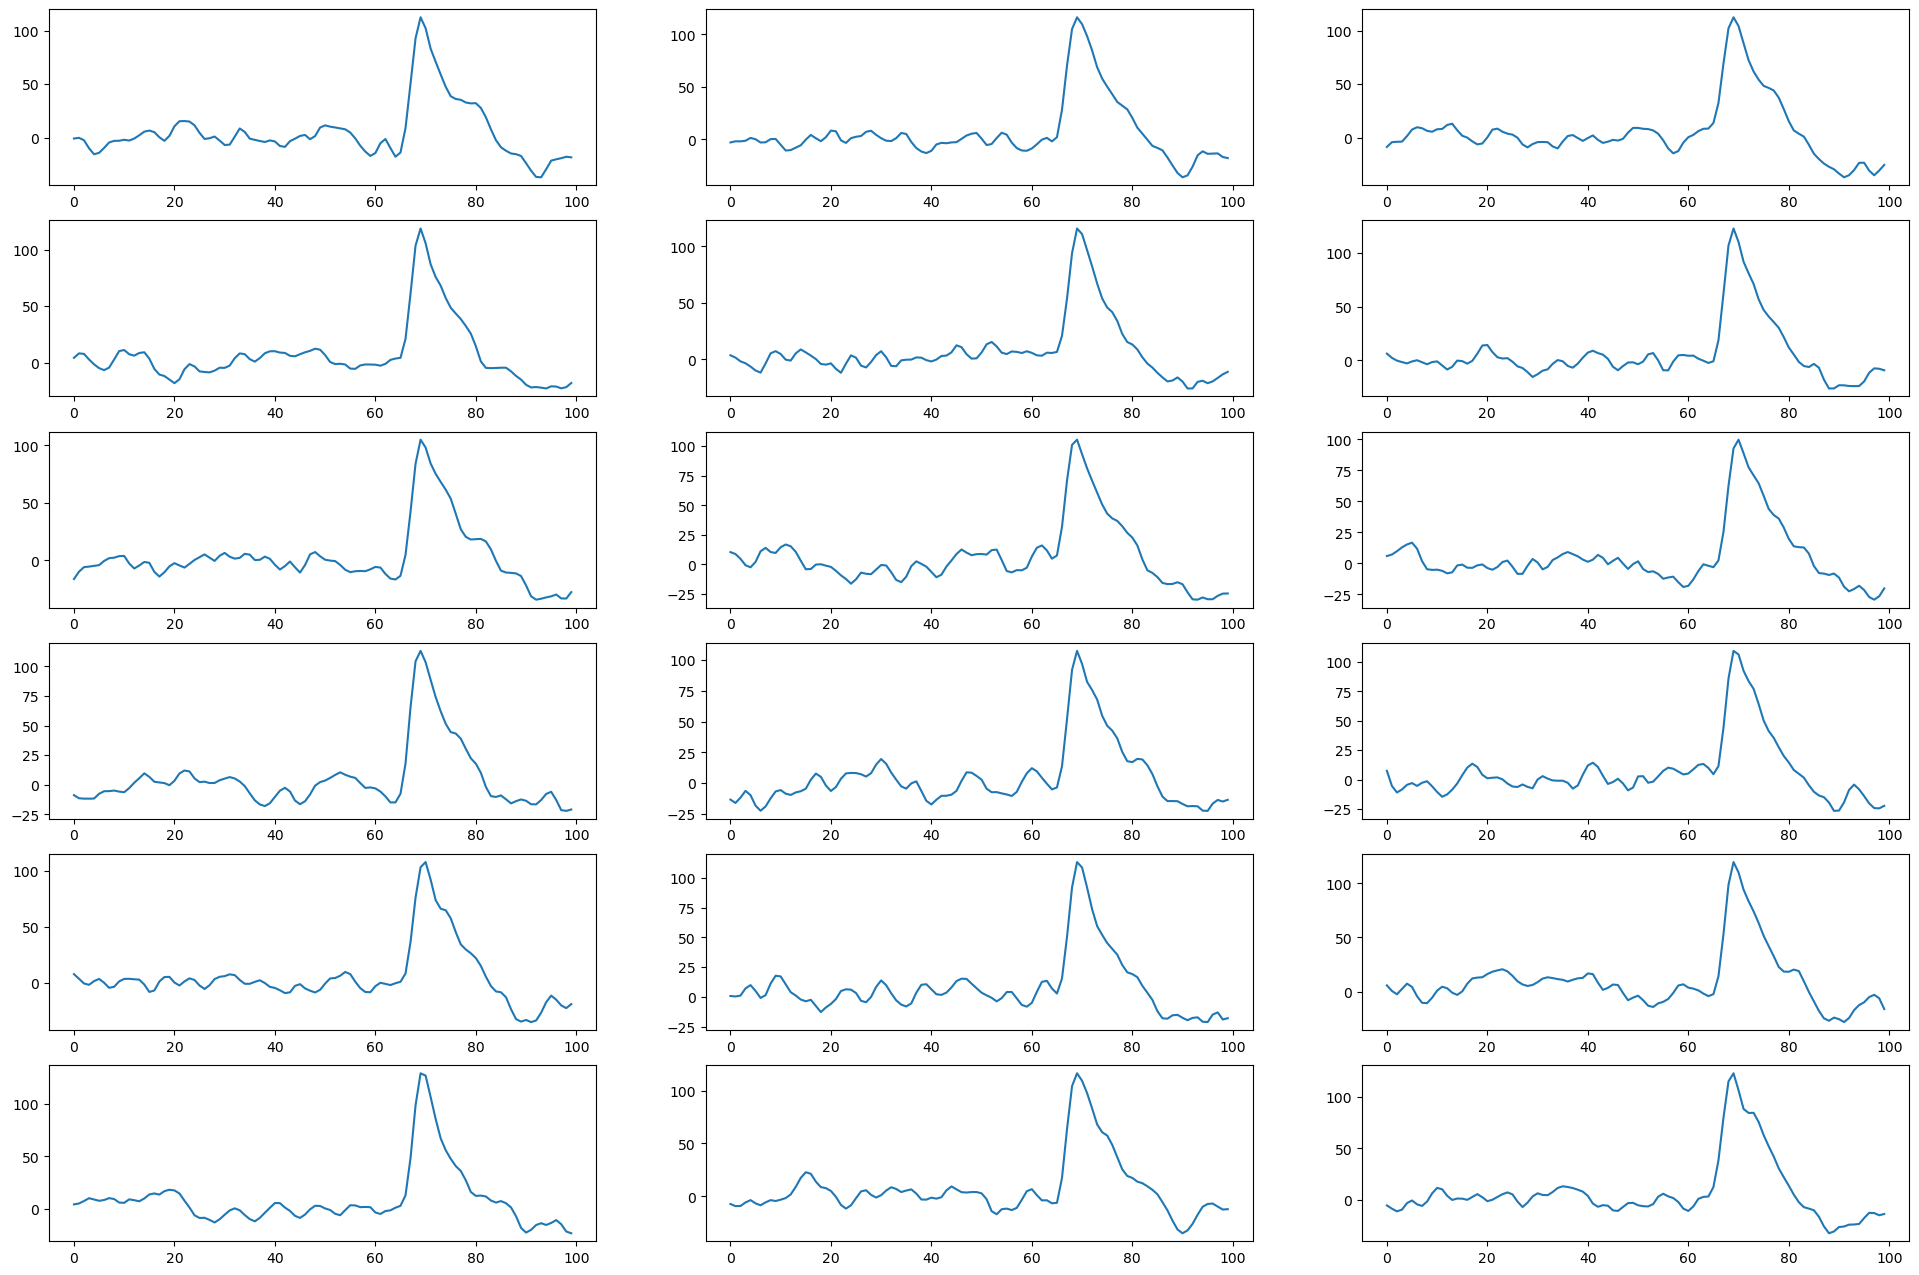

In [6]:
plot_clusters_by_class(1)

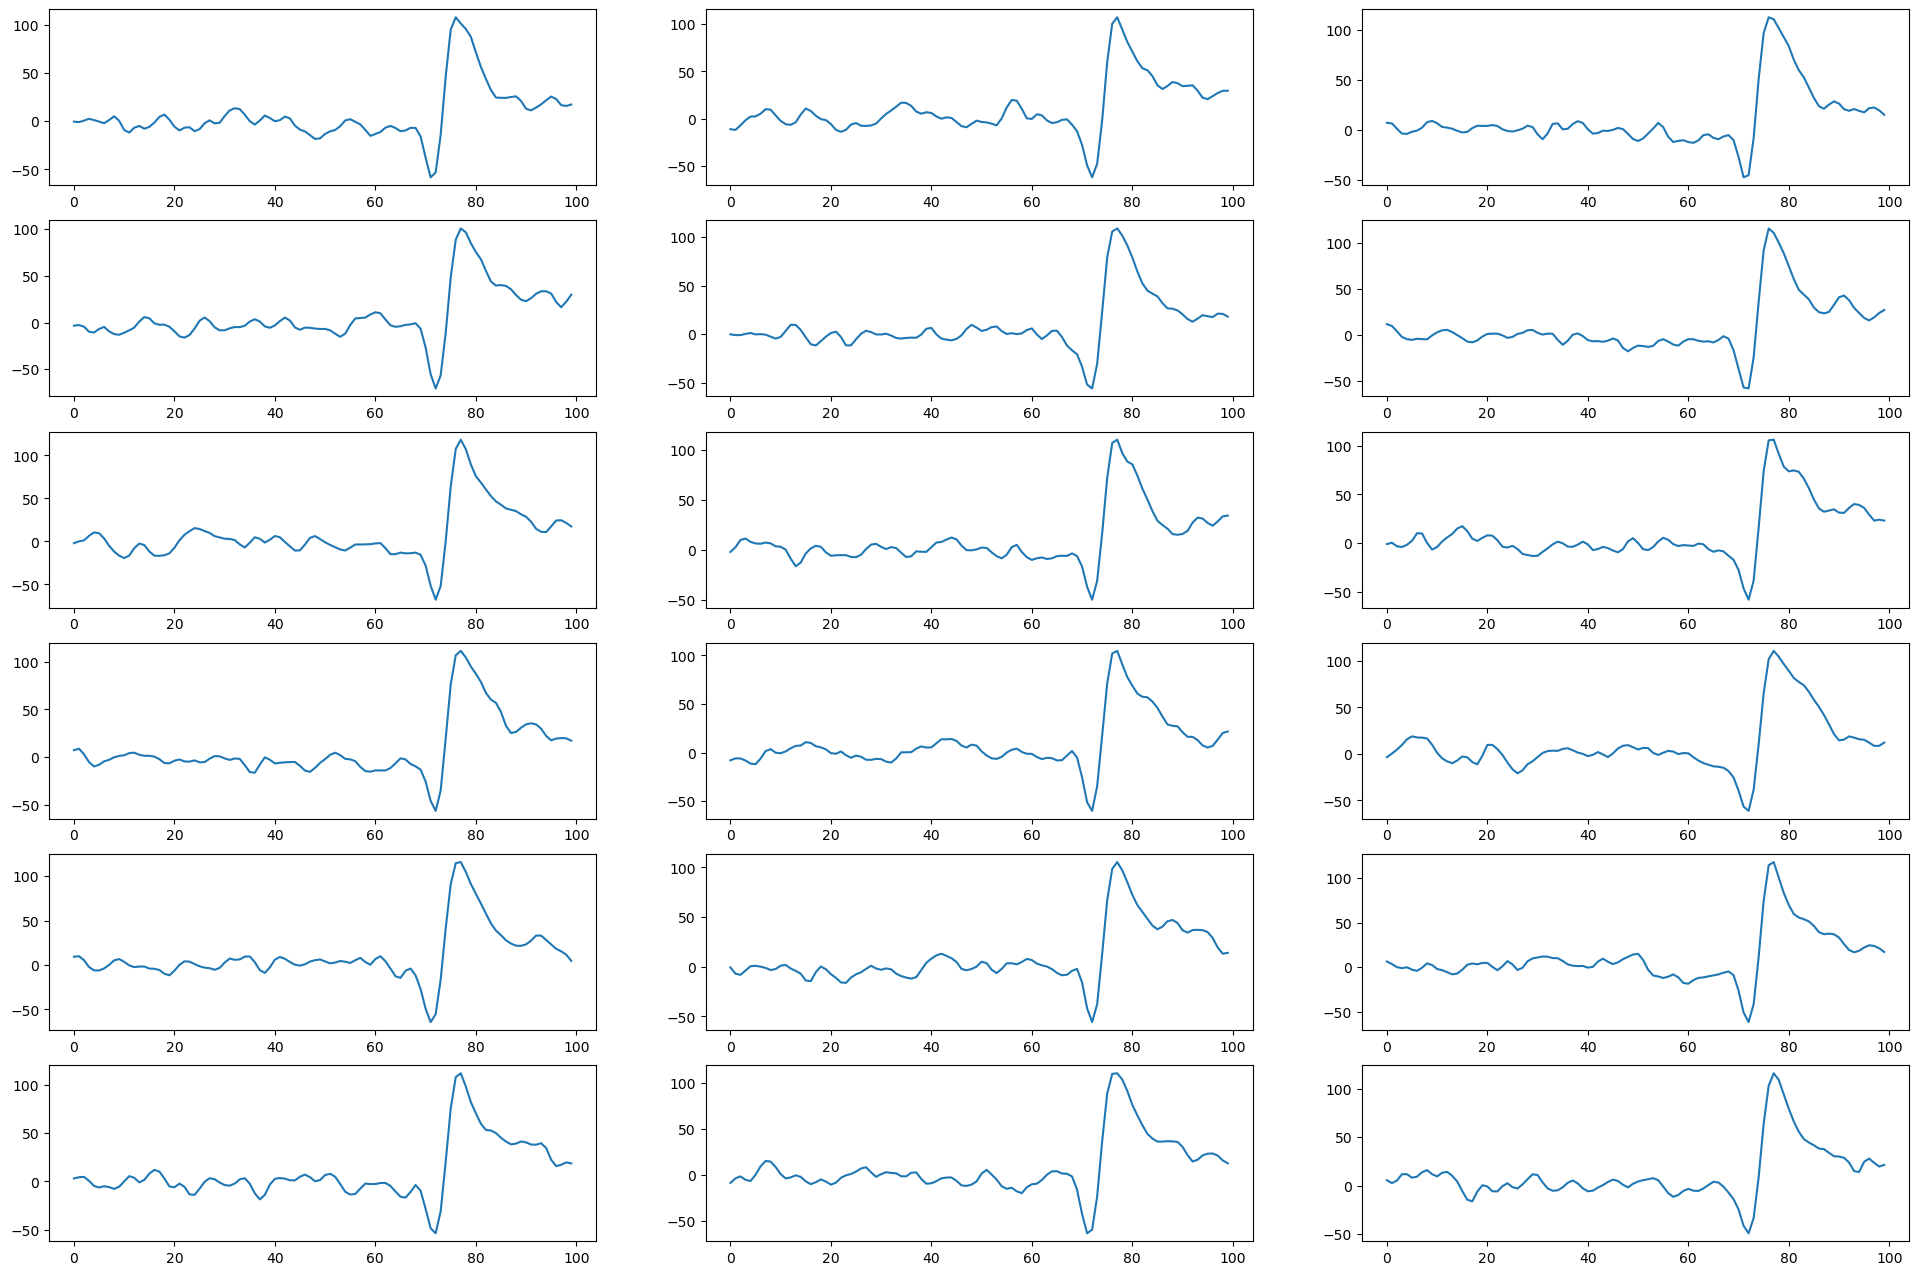

In [7]:
plot_clusters_by_class(2)

# Finding Spikes in the Data

In [14]:
# params
interval_param = 25
threshold_param = 2.7

# data
data = mat_file['data'][0]
spike_times = mat_file['spike_times'][0][0][0]


# mean and stdv
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)


threshold = mean + threshold_param * std_dev

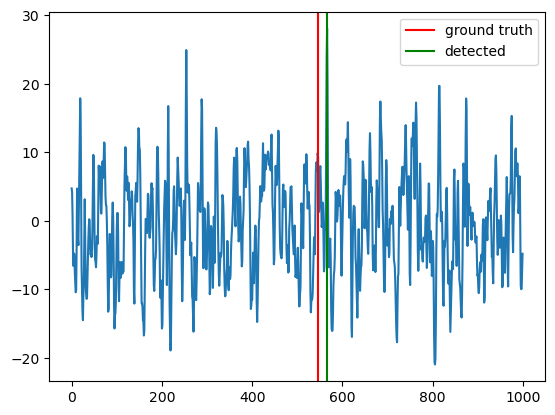

In [15]:
detected_spikes = []

for i in range(data.shape[0]-1):
    # TODO: Try Z-Score, Optimize parameters
    if data[i] < threshold and data[i+1] >= threshold:
        detected_spikes.append(i)
        
detected_spikes = np.array(detected_spikes).reshape(-1,1)

# TODO: Recreate Ground truth plot --> Extend time frame and use subplots

plt.plot(data[0:1000])


plt.axvline(spike_times[np.where(spike_times<1000)], color='red', label="ground truth")

# plt.axvline(detected_spikes[np.where(detected_spikes<1000)], color='red', label="ground truth")
for detected in detected_spikes:
    if detected < 1000:
        plt.axvline(detected, color='green', label="detected")

plt.legend()
plt.show()